In [1]:
train_dir = "/kaggle/input/teeth-task1/Teeth_Dataset/Training"
val_dir = "/kaggle/input/teeth-task1/Teeth_Dataset/Validation"
test_dir = "/kaggle/input/teeth-task1/Teeth_Dataset/Testing"

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Verify class labels
print("Class Labels:", train_generator.class_indices)



Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1508 images belonging to 10 classes.
Class Labels: {'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [3]:
#We got 10 classes in testing due to the output, outputs, out, and output_image. We need it to be 7 
allowed_classes = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']  # Only valid classes

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    classes=allowed_classes  # Ignore unwanted folders
)


Found 1028 images belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


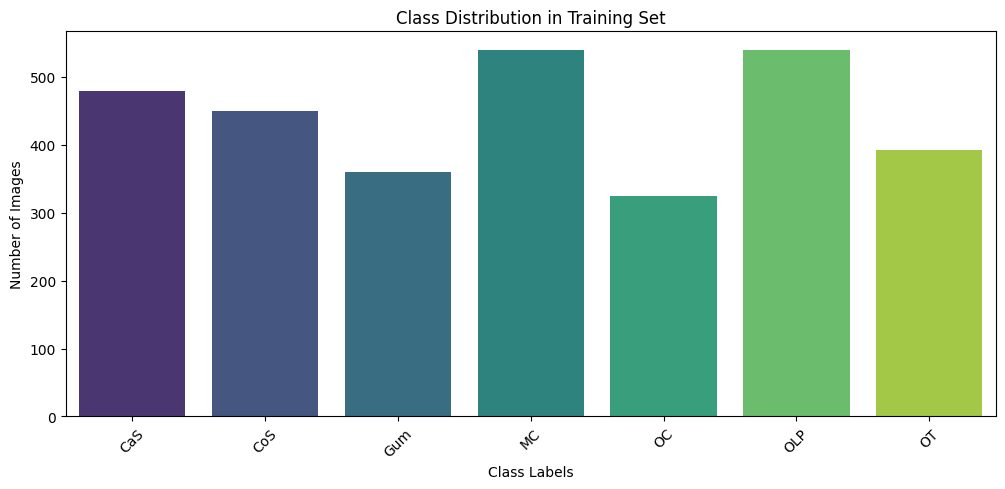

In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Function to count images in each class
def count_images(directory):
    class_counts = {}
    for category in sorted(os.listdir(directory)): 
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path): 
            class_counts[category] = len(os.listdir(category_path))
    return class_counts

# Get counts for train, validation, and test sets
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Plot distributions
plt.figure(figsize=(12, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=45)
plt.show()

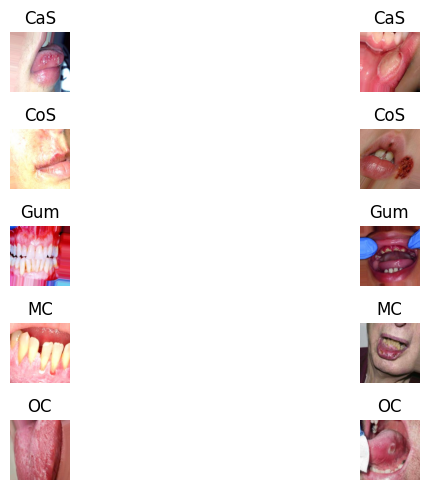

In [5]:
import random
import cv2

# Function to display sample images
def show_sample_images(directory, num_images=2):
    plt.figure(figsize=(10, 5))
    class_labels = sorted(os.listdir(directory))

    for i, category in enumerate(class_labels[:5]):  # Show first 5 classes
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            image_files = os.listdir(category_path)
            random_images = random.sample(image_files, min(num_images, len(image_files)))

            for j, img_name in enumerate(random_images):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)  
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

                plt.subplot(5, num_images, i * num_images + j + 1)
                plt.imshow(img)
                plt.title(category)
                plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display images from training dataset
show_sample_images(train_dir)


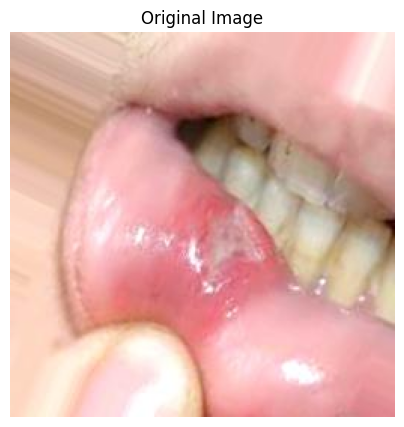

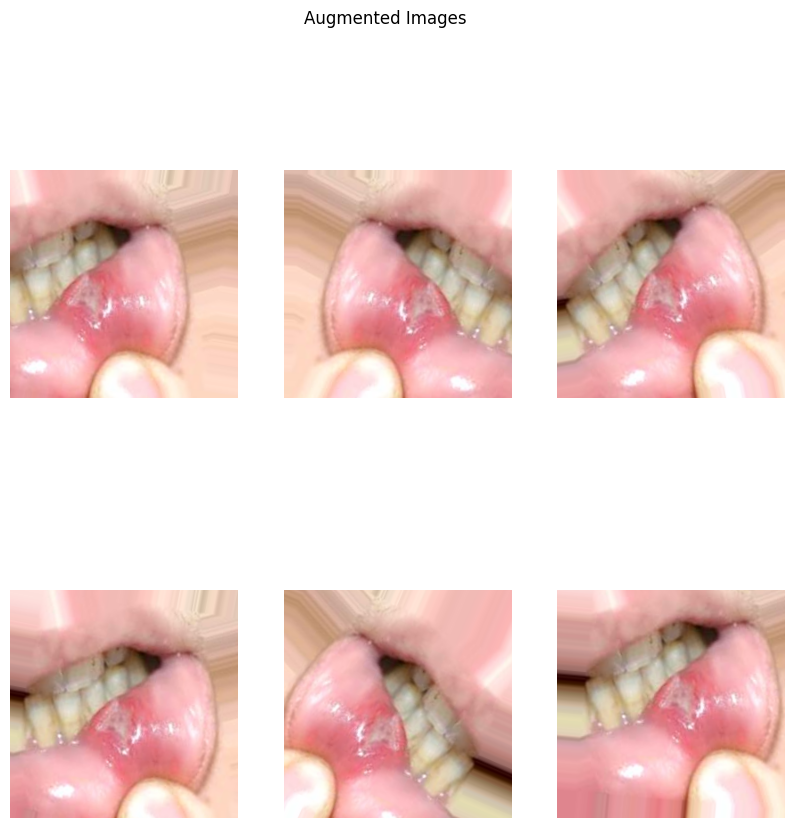

In [6]:
import cv2
import numpy as np

# Define a class folder 
sample_class = "CaS"
sample_folder = os.path.join(test_dir, sample_class)

# Get a random image path
sample_image_name = np.random.choice(os.listdir(sample_folder))
sample_image_path = os.path.join(sample_folder, sample_image_name)

# Load and display the original image
original_image = cv2.imread(sample_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  

plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")
plt.show()

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

# Convert image to array and reshape for generator
img_array = img_to_array(original_image)  
img_array = np.expand_dims(img_array, axis=0)  

# Generate augmented images
augmented_images = train_datagen.flow(img_array, batch_size=1)

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(6):  
    augmented_img = next(augmented_images)[0] 
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_img)
    plt.axis("off")

plt.suptitle("Augmented Images")
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



#CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # **Replace Flatten with GAP to reduce parameters**
    GlobalAveragePooling2D(),  

    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(7, activation='softmax')  
])

# Compile with SGD
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 559ms/step - accuracy: 0.1955 - loss: 1.9614 - val_accuracy: 0.1508 - val_loss: 1.9280 - learning_rate: 0.0100
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 437ms/step - accuracy: 0.2872 - loss: 1.7783 - val_accuracy: 0.1449 - val_loss: 2.1461 - learning_rate: 0.0100
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 430ms/step - accuracy: 0.3208 - loss: 1.7423 - val_accuracy: 0.1994 - val_loss: 2.0866 - learning_rate: 0.0100
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 430ms/step - accuracy: 0.3127 - loss: 1.7173 - val_accuracy: 0.2354 - val_loss: 1.8531 - learning_rate: 0.0100
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.3370 - loss: 1.6736 - val_accuracy: 0.2850 - val_loss: 1.7505 - learning_rate: 0.0100
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.3487 - loss: 1.6632 - val_accuracy: 0.3074 - val_loss: 1.6859 - learning_rate: 0.0100
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 431ms/step - accuracy: 0.3716 - loss: 1.6008 - val_

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Define the model
model_1 = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(256, 256, 3)),
    LeakyReLU(alpha=0.01),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    GlobalAveragePooling2D(),  

    Dense(256, activation='relu'),
    Dropout(0.5),  
    Dense(7, activation='softmax')  
])

# Compile the model with Adam optimizer
model_1.compile(
    optimizer=Adam(learning_rate=0.01),  # <== Fixed Adam optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  
    callbacks=[lr_scheduler, early_stopping]
)

# Evaluate on test set
test_loss, test_acc = model_1.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 486ms/step - accuracy: 0.1975 - loss: 2.4694 - val_accuracy: 0.2130 - val_loss: 2.0192 - learning_rate: 0.0100
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 46s 438ms/step - accuracy: 0.2840 - loss: 1.7986 - val_accuracy: 0.1887 - val_loss: 2.7134 - learning_rate: 0.0100
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.3055 - loss: 1.7812 - val_accuracy: 0.1167 - val_loss: 6.8940 - learning_rate: 0.0100
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 428ms/step - accuracy: 0.2772 - loss: 1.7743 - val_accuracy: 0.2510 - val_loss: 2.1443 - learning_rate: 0.0100
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 438ms/step - accuracy: 0.3323 - loss: 1.6841 - val_accuracy: 0.2626 - val_loss: 1.8774 - learning_rate: 0.0050
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.3515 - loss: 1.6352 - val_accuracy: 0.2685 - val_loss: 1.9399 - learning_rate: 0.0050
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 45s 435ms/step - accuracy: 0.3511 - loss: 1.

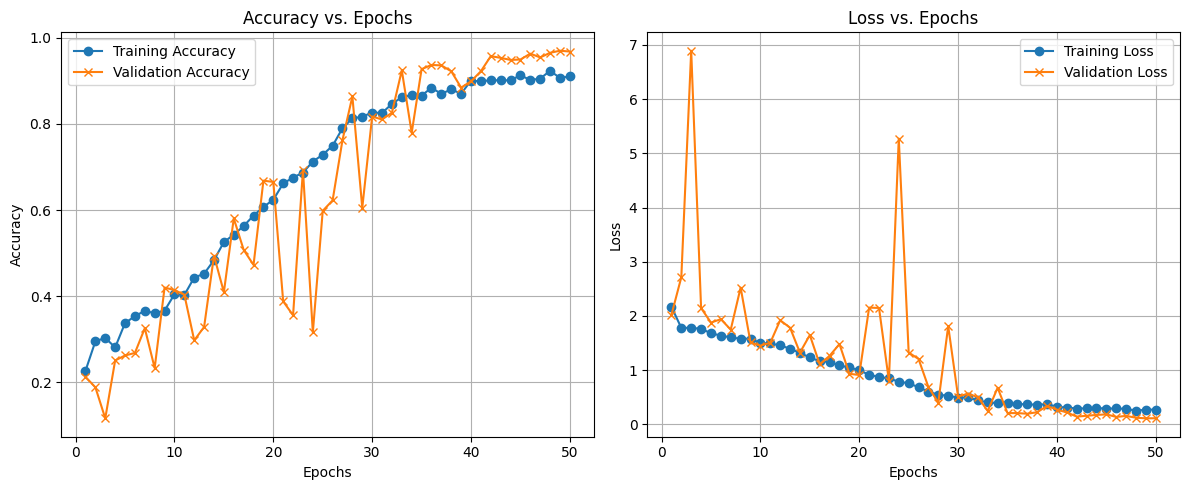

In [12]:
import matplotlib.pyplot as plt

# Extract metrics from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
